In [1]:
# %%px
use_dolfinx = True
nprocs = 8

### colab

In [2]:
# %%px
import os
colab = os.getcwd() == "/content"


In [3]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


In [5]:
# %%px
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

### parallel

In [6]:
## Parallel programming imports
import ipyparallel as ipp
from mpi4py import MPI

In [7]:
os.environ["OMPI_ALLOW_RUN_AS_ROOT"] = "1"
os.environ["OMPI_ALLOW_RUN_AS_ROOT_CONFIRM"] = "1"

cluster = ipp.Cluster(
    engines="mpi",
    n=nprocs,
    engine_launcher_args={
        "mpirun_args": [
            "--allow-run-as-root",         # già confermato con variabili ma non guasta
            "--use-hwthread-cpus"          # 1: conta gli hw threads come slot
            # oppure: "--map-by", ":OVERSUBSCRIBE"
        ]
    }
)
rc = cluster.start_and_connect_sync()
print("Engine MPI avviati correttamente!")


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

Engine MPI avviati correttamente!


### dolfinx

In [8]:
%%px
use_dolfinx = True

In [9]:
%%px
import os
colab = os.getcwd() == "/content"

In [10]:
%%px
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

### import

In [11]:
%%px
from __future__ import print_function


In [12]:
%%px
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
if colab:
    if use_dolfinx:
        import gmsh
        from mpi4py import MPI
        from petsc4py import PETSc

        from basix.ufl import element

        from dolfinx.fem import (
            Constant,
            Function,
            functionspace,
            assemble_scalar,
            dirichletbc,
            form,
            locate_dofs_topological,
            set_bc,
        )
        from dolfinx.fem.petsc import (
            apply_lifting,
            assemble_matrix,
            assemble_vector,
            create_vector,
            create_matrix,
            set_bc,
        )
        from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
        from dolfinx.io import VTXWriter, gmshio
        from ufl import (
            FacetNormal,
            Measure,
            TestFunction,
            TrialFunction,
            as_vector,
            div,
            dot,
            dx,
            inner,
            lhs,
            grad,
            nabla_grad,
            rhs,
        )

        gmsh.initialize()

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stderr:1] WARNING:py.warnings:/tmp/ipykernel_20402/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:3] WARNING:py.warnings:/tmp/ipykernel_20404/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:4] WARNING:py.warnings:/tmp/ipykernel_20405/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:7] WARNING:py.warnings:/tmp/ipykernel_20408/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:2] WARNING:py.warnings:/tmp/ipykernel_20403/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:5] WARNING:py.warnings:/tmp/ipykernel_20406/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:6] WARNING:py.warnings:/tmp/ipykernel_20407/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:0] WARNING:py.warnings:/tmp/ipykernel_20401/2342725566.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



In [13]:
%%px
from IPython.display import clear_output as clc

plt.style.use("default")


In [14]:
%%px
if colab:
    if use_dolfinx:
        import ufl
        from basix.ufl import element, mixed_element
        from dolfinx import fem, la
        from dolfinx.fem import (Constant, Function, dirichletbc,
                                extract_function_spaces, form, functionspace,
                                locate_dofs_topological)
        from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
        from dolfinx.io import XDMFFile
        from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
        from ufl import div, dx, grad, inner
        from ufl import CellDiameter, sqrt, FacetArea

In [15]:
%%px
from scipy.interpolate import RBFInterpolator

In [16]:
%%px
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [17]:
%%px
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [18]:
%%px
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1, c = None):
    if not c==None:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c)
    else:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [19]:
%%px
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

# Parameters

In [20]:
%%px
L = 25
H = 10
# N_points = 121  # numero di punti per la discretizzazione dell'airfoil
chord = 1

# Airfoil parameters
chord = 1  # Adjust as needed
Aoa = 20
# N_points = 121
# c_x, c_y = 0.2 * L + 0.5 * chord, H / 2
x_le, y_le = 0.3 * L, 0.5 * H

# Pinball parameters
R = 0.5
l = 3*R
centers = [[0.25*L, H/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 + l/2],
           [0.25*L + l*(np.sqrt(3)/2), H/2 - l/2]]

if colab:
    if use_dolfinx:
        mesh_comm = MPI.COMM_WORLD
        model_rank = 0
        gdim = 2

# Physical and discretization parameters
t = 0
T = 10 # Final time
dt = 0.05  # Time step size
timesteps = int(T / dt)
mu_ = 0.01
rho_ = 1
U_max = 3
Re = (U_max * 2 / 3) * chord * rho_ / mu_
print(f"Re: {Re:.2f}")

save_numpy_unsteady = True
save_to_np_every_steps = 1
# save_to_torch_every_steps = 1
save_to_np_every_steps = 1

[stdout:2] Re: 200.00


[stdout:5] Re: 200.00


[stdout:4] Re: 200.00


[stdout:3] Re: 200.00


[stdout:7] Re: 200.00


[stdout:6] Re: 200.00


[stdout:0] Re: 200.00


[stdout:1] Re: 200.00


# Utilities

### Airfoil utilities

In [21]:
%%px
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [22]:
%%px
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [23]:
%%px
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))


In [24]:
%%px
if colab:
    if use_dolfinx:
        from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [25]:
%%px
def get_markers_and_nodes():
    markers = [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker] = [1, 2, 3, 4, 5]
    lists = [[], [], [], [], []]
    for node_list, marker in list(zip(lists, markers)):
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, marker)

        for i, tag in enumerate(node_tags):
            x = node_coords[3 * i]       # coordinata x
            y = node_coords[3 * i + 1]   # coordinata y
            node_list.append([x, y])

    return  markers, lists[1:]

In [26]:
%%px
def interpolate_mesh(mesh, control_points, displacements):
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q = functionspace(mesh, s_cg1)
    mesh_coords = np.array(Q.tabulate_dof_coordinates())

    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(mesh_coords[:, :2])
    mesh.geometry.x[:, :2] = mesh_coords[:, :2] + displacements

    return mesh

In [27]:
%%px
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [28]:
%%px
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    # print(N_points)
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    # print(airfoil_control_points_ids.shape)
    # print(airfoil_control_points_ids)
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


### dolfinx utilities

In [29]:
%%px
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # U_max * np.sin(self.t * np.pi / 8)
            # U_max * np.cos(self.alpha)
            # 4 * self.U_max * x[1] * (H - x[1]) / (H**2) * np.cos(self.alpha)
            self.U_max
        )
        values[1] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # 4 * U_max * x[1] * (H - x[1]) / (H**2)
            # 4 * self.U_max * x[1] * (H - x[1]) / (H**2) * np.sin(self.alpha)
            0
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha, bcwalls="freeslip"):

    fdim = mesh.topology.dim - 1

    # Define boundary conditions
    # Inlet
    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)
    bcu_inflow = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker))
    )

    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)

    # Obstacle
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )
    bcu = [bcu_inflow, bcu_obstacle]

    # # Outlet
    # bcp_outlet = dirichletbc(
    #     PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q
    # )
    # bcp = [bcp_outlet]
    bcp = []

    # Walls
    # freeslip
    if bcwalls=="freeslip":
        walls_dofs_y = locate_dofs_topological(V.sub(1), mesh.topology.dim - 1, ft.find(wall_marker))
        bcu_walls = dirichletbc(dolfinx.default_scalar_type(0), walls_dofs_y, V.sub(1))
        bcu.append(bcu_walls)
    # noslip
    elif bcwalls=="noslip":
        bcu_walls = dirichletbc(
            u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V
        )
        bcu.append(bcu_walls)
    # freestream
    elif bcwalls=="freestream":
        bcu_walls = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(wall_marker))
        )
        bcu_outlet = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(outlet_marker))
        )
        # bcp_walls = dirichletbc(
        #     PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(wall_marker)), Q
        # )
        bcu.append(bcu_walls)
        bcu.append(bcu_outlet)
        # bcp.append(bcp_walls)
        pass

    return bcu, bcp, u_inlet, inlet_velocity

In [30]:
%%px
from petsc4py import PETSc

def solve(params, mesh, facet_tags, dt, num_steps, U_max, rho_, save_to_np_every_steps = 10, bcwalls="freeslip", backflow=False):

    comm = MPI.COMM_WORLD
    rank = comm.rank

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    # U_max_0 = params[1][0]
    alpha_0 = params[0][0]
    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max, alpha_0, bcwalls)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(params[1][0]))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    residual_momentum = (
        rho / k * (u - u_n)
        + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
        - div(mu * grad(u)) + grad(p_)
    )

    if backflow:
        n        = FacetNormal(mesh)
        ds       = Measure("ds", domain=mesh, subdomain_data=facet_tags)
        C_bf     = Constant(mesh, PETSc.ScalarType(0.5))

    # F1_SUPG = F1 + tau_supg * dot(residual_momentum, v) * dx
    # a1 = form(lhs(F1_SUPG))
    # L1 = form(rhs(F1_SUPG))
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    # solver1 = PETSc.KSP().create(mesh.comm)
    # solver1.setOperators(A1)
    # solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    # solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
    # pc1 = solver1.getPC()
    # pc1.setType(PETSc.PC.Type.LU)
    # pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
    # # solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

    # solver2 = PETSc.KSP().create(mesh.comm)
    # solver2.setOperators(A2)
    # solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    # solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    # pc2 = solver2.getPC()
    # pc2.setType(PETSc.PC.Type.LU)
    # pc2.setFactorSolverType("mumps")
    # # solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

    # solver3 = PETSc.KSP().create(mesh.comm)
    # solver3.setOperators(A3)
    # solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    # solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    # pc3 = solver3.getPC()
    # pc3.setType(PETSc.PC.Type.LU)
    # pc3.setFactorSolverType("mumps")
    # # solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.JACOBI)

    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.MINRES)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")

    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)

    # Eseguire prima set up initial set up in steady problem
    u_ns = Function(Q_vectorial)
    u_ns.interpolate(u_)
    # U = np.expand_dims(u_ns_unsteady.x.array, 0)

    # p_np = np.zeros_like(p_.x.array).reshape(1, -1)

    # For collecting global solutions
    U_time_series = []
    p_time_series = []

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0.0

    threshold = 100.0
    norm_check_every_steps = 5

    backflow_rate=0.0

    for i in range(num_steps):
        # avanzamento tempo
        t += dt

        progress.update(1)

        if i%norm_check_every_steps==0:
            # calcolo norme
            u_norm = np.sqrt(
                mesh_comm.allreduce(
                    assemble_scalar(form((u_)**2 * dx)),
                    MPI.SUM
                )
            )
            # p_norm = np.sqrt(
            #     mesh_comm.allreduce(
            #         assemble_scalar(form((p_)**2 * dx)),
            #         MPI.SUM
            #     )
            # )

            # ——— controllo divergenza ———
            if (u_norm > threshold):
                # if rank == 0:
                raise RuntimeError(
                    f"Soluzione divergente a passo {i+1}, t={t:.3f}: "
                    f"||u||_L2={u_norm:.3e}", #, ||p||_L2={p_norm:.3e}"
                    )
                # else:
                #     # gli altri rank fanno abort
                #     MPI.COMM_WORLD.Abort(1)

        # aggiorno la barra
        postfix_ = {
            't': f"{t:.1f}",
            '||u||_L2': f"{u_norm:.1f}",
            # '||p||_L2': f"{p_norm:.1f}",
        }
        if backflow:
            postfix_["Backflow rate"] = f"{backflow_rate:.3e}"
        progress.set_postfix(postfix_)


        # Update inlet velocity
        # inlet_velocity.t = t
        # inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()

        # Step 2: Pressure corrrection step
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()

        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()

        # Step 3: Velocity correction step
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # clc(wait = True)

        if i % save_to_np_every_steps == 0:
            # --- Gather velocity on Q_vectorial (owned DOFs only), preserving both components ---
            u_ns = Function(Q_vectorial)
            u_ns.interpolate(u_)
            arr_u = u_ns.x.array
            im_u = Q_vectorial.dofmap.index_map
            # reshape to (n_local, 2) so arr2[j] = [u_x, u_y]
            arr2 = arr_u.reshape(-1, mesh.geometry.dim)
            # select owned nodes
            local_idxs = np.arange(im_u.size_local, dtype=np.int32)
            owned = np.setdiff1d(local_idxs, im_u.ghosts, assume_unique=True)
            vals2 = arr2[owned, :]        # shape (n_owned, 2)
            vals_u = vals2.ravel()        # interleaved [u_x, u_y]
            # gather across ranks
            gathered_vals_u = comm.gather(vals_u, root=0)
            gathered_gl_u   = comm.gather(im_u.local_to_global(owned), root=0)
            if rank == 0:
                Ug = np.zeros((1, im_u.size_global * mesh.geometry.dim), dtype=vals_u.dtype)
                for vals, gl in zip(gathered_vals_u, gathered_gl_u):
                    # gl is length n_owned, we must map interleaved
                    for idx_local, gf in enumerate(gl):
                        Ug[0, 2*gf    ] = vals[2*idx_local]
                        Ug[0, 2*gf + 1] = vals[2*idx_local + 1]
                U_time_series.append(Ug.ravel())


            # --- Gather pressure on Q (owned DOFs only) ---
            arr_p = p_.x.array - domain_average(mesh, p)
            im_p = Q.dofmap.index_map
            local_idxs_p = np.arange(im_p.size_local, dtype=np.int32)
            owned_p = np.setdiff1d(local_idxs_p, im_p.ghosts, assume_unique=True)
            vals_p = arr_p[owned_p]
            gathered_vals_p = comm.gather(vals_p, root=0)
            gathered_glp    = comm.gather(im_p.local_to_global(owned_p), root=0)
            if rank == 0:
                Pg = np.zeros((1, im_p.size_global), dtype=vals_p.dtype)
                for vals, glp in zip(gathered_vals_p, gathered_glp):
                    Pg[0, glp] = vals
                p_time_series.append(Pg.ravel())


        # Update variable with solution form this time step
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

        if backflow:
            un_n     = dot(u_n, n)                    # u_n · n
            abs_un_n = sqrt(un_n*un_n)                # |u_n · n|
            min_un0  = 0.5*(abs_un_n + un_n)          # = max(un_n, 0)
            backflow_weight = rho * C_bf * min_un0     # >0 se backflow su u_n

            # dentro la definizione di F1, prima di form(lhs(F1))
            F1 += backflow_weight * dot(u, v) * (ds(outlet_marker) + ds(wall_marker))

            a1 = form(lhs(F1))
            L1 = form(rhs(F1))

            # backflow vero basato su u_ (ultima soluzione)
            un_val = dot(u_, n)
            backflow_flux = assemble_scalar(
                form(ufl.conditional(un_val < 0, un_val, 0) * (ds(outlet_marker) + ds(wall_marker)))
            )
            backflow_rate = mesh_comm.allreduce(backflow_flux, MPI.SUM)

    progress.close()

    if rank == 0:
        return np.vstack(U_time_series), np.vstack(p_time_series)
    else:
        return None, None

# Snapshots

In [31]:
%%px
comm = MPI.COMM_WORLD
rank = comm.rank

In [32]:
%%px
# gmsh.initialize()
gmsh.open("pinball_mesh_bigger.msh")

partitioner = dolfinx.mesh.create_cell_partitioner(dolfinx.mesh.GhostMode.shared_facet)
mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim, partitioner=partitioner)
ft = facet_tags

[stdout:3] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


[stdout:2] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


[stdout:5] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


[stdout:7] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


[stdout:4] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


[stdout:0] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


[stdout:1] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


[stdout:6] Info    : Reading 'pinball_mesh_bigger.msh'...
Info    : 18 entities
Info    : 29340 nodes
Info    : 58684 elements
Info    : Done reading 'pinball_mesh_bigger.msh'


In [33]:
%%px
[fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker], [inlet_nodes, outlet_nodes, wall_nodes, obstacle_nodes] = get_markers_and_nodes()
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
pinball_coords = np.array(obstacle_nodes)
N_points = pinball_coords.shape[0]

# if mesh_comm.rank == model_rank:
quality = gmsh.model.mesh.getNodes()
print(f"Mesh has {len(quality[0])} nodes.")

[stdout:0] Mesh has 29340 nodes.


[stdout:7] Mesh has 29340 nodes.


[stdout:2] Mesh has 29340 nodes.


[stdout:1] Mesh has 29340 nodes.


[stdout:4] Mesh has 29340 nodes.


[stdout:3] Mesh has 29340 nodes.


[stdout:5] Mesh has 29340 nodes.


[stdout:6] Mesh has 29340 nodes.


In [34]:
%%px

s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
Q_vec = functionspace(mesh, s_cg1)

im = Q_vec.dofmap.index_map
N = im.size_global
# Alloco un array di coordinate (N, 2) su rank 0
coords_global = np.zeros((N, 3))

# Su ogni rank preparo
coords_local = Q_vec.tabulate_dof_coordinates()     # (size_local, 2)
local_idxs   = np.arange(im.size_local, dtype=int)
owned        = np.setdiff1d(local_idxs, im.ghosts)
global_idxs  = im.local_to_global(owned)           # lunghezza = n_owned
coords_owned = coords_local[owned]

# Gather di (coords_owned, global_idxs) su rank 0
gathered_coords = comm.gather(coords_owned,   root=0)
gathered_globs  = comm.gather(global_idxs,    root=0)

if rank==0:
    # Riempi il coords_global usando i global indices
    for pts, gl in zip(gathered_coords, gathered_globs):
        coords_global[gl, :] = pts

    # np.savez("data/pinball_data.npz", naca0012_airfoil_coords = pinball_coords, naca0012_coords = coords_global)


In [35]:
%%px
ntrajectories = 1
nparams = 2 #inlet velocity
# nvelocity = VectorFunctionSpace(mesh, "CG", 2).dim()
npressure = coords.shape[0]

In [36]:
%%px
Reynolds_range = (50, 200)
mu_range = tuple([(2*R * rho_ * U_max / Re_i) for Re_i in Reynolds_range])

params_ph_range = [(-0.0, 0.0), mu_range, ] # Physical parameters: angle of attack and inflow intensity
# params_airfoil_range = [(0.0, 0.05 * chord), (0.3 * chord, 0.6 * chord), (0.09 * chord, 0.15 * chord)] # Airfoil parameters: max camber, camber position, max thickness
params_range = params_ph_range # + params_airfoil_range

In [37]:
%%px

dt = 0.02
T = 10
timesteps = int(T/dt)


save_to_np_every_steps = 25
ntimes = int(timesteps/save_to_np_every_steps) + 1 # initial condition


In [38]:
%%px
np.random.seed(42)

In [ ]:
%%px
if rank==0:
    U = np.zeros((ntrajectories, ntimes, N))
    V = np.zeros((ntrajectories, ntimes, N))
    P = np.zeros((ntrajectories, ntimes, N))
    MU = np.zeros((ntrajectories, ntimes, nparams))

    os.makedirs("snapshots_pinball", exist_ok=True)

for i in range(0, ntrajectories):

    if rank==0:
        print(f"Generating snapshot n.{i}...")

    # params = [0] * len(params_range)
    # for j in range(len(params_range)):
    #     params[j] = ((params_range[j][1] - params_range[j][0]) * np.random.rand(1) + params_range[j][0]).item()
    params = [[param_i] * (timesteps+1) for param_i in [0.0, 0.006]] # shape (n_params, n_timesteps)

    if rank==0:
        print(f"U_max: {U_max} [m/s]")
        print(f"mu: {params[1][0]:.4f}")
        print(f"Aoa: {params[0][0] * 180 / np.pi:.1f}°")
        print(f"Re: {U_max * np.cos(params[0][0]) * 2 * R  * rho_ / params[1][0]:.1f}")

    [U_np, p_np] = solve(params, mesh, facet_tags, dt, timesteps+1, U_max, rho_, save_to_np_every_steps, bcwalls="freestream", backflow=False)

    if rank==0:
        U_np = U_np.reshape((U_np.shape[0], -1, 2))
        u_np, v_np = U_np[:,:,0], U_np[:,:,1]

        U[i] = u_np
        V[i] = v_np
        P[i] = p_np

        for j, param_j in enumerate(params, 0):
            MU[i, :, j] = np.array(param_j[::save_to_np_every_steps])


        clc(wait = True)

        # np.savez(f"snapshots_pinball/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

print("Snapshots generated!")

# np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

[stdout:0] Generating snapshot n.0...
U_max: 3 [m/s]
mu: 0.0060
Aoa: 0.0°
Re: 500.0


[output:4]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

[output:5]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

[output:3]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

[output:1]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

[output:7]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

[output:6]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

[output:2]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

[output:0]

Solving PDE:   0%|          | 0/501 [00:00<?, ?it/s]

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

In [ ]:
# %%px
# # [u_np, v_np, p_np] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_np_every_steps)
# [U_np, p_np] = solve(params, mesh, facet_tags, dt, timesteps, U_max, rho_, save_to_np_every_steps)

In [65]:
%%px
if rank==0:
    U = U_np.reshape((U_np.shape[0], -1, 2))
    u, v = U[:,:,0], U[:,:,1]


In [66]:
%%px
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

if rank==0:
    # Ora coords_global ha shape (11289,2)
    x = coords_global[:,0]
    y = coords_global[:,1]
    triang = tri.Triangulation(x, y)

    # Calcola la magnitudine di u per tutti i timestep e determina min e max globali
    # u_mag = np.sqrt(u**2 + v**2)
    u_min, u_max = u.min(), u[:50].max()
    v_min, v_max = v.min(), v[:50].max()
    p_min, p_max = p_np[1:85 ,:].min(), p_np[1:85 ,:].max()

    # Crea gli oggetti norm per fissare la scala dei colori
    norm_u = mcolors.Normalize(vmin=u_min, vmax=u_max)
    norm_v = mcolors.Normalize(vmin=v_min, vmax=v_max)
    norm_p = mcolors.Normalize(vmin=p_min, vmax=p_max)

    # Crea due ScalarMappable per le colorbar statiche
    sm_u = ScalarMappable(cmap='jet', norm=norm_u)
    sm_u.set_array([])
    sm_v = ScalarMappable(cmap='jet', norm=norm_v)
    sm_v.set_array([])
    sm_p = ScalarMappable(cmap='jet', norm=norm_p)
    sm_p.set_array([])
    # Imposta la figura con 2 sottotrame
    scale = 2
    nrows = 1
    ncols = 2

    cyl_coords = []
    cyl_coords.append(pinball_coords[np.where((pinball_coords[:, 0] - centers[0][0])**2 + (pinball_coords[:, 1] - centers[0][1])**2 <= (R + 1e-3)**2)])
    cyl_coords.append(pinball_coords[np.where((pinball_coords[:, 0] - centers[1][0])**2 + (pinball_coords[:, 1] - centers[1][1])**2 <= (R + 1e-3)**2)])
    cyl_coords.append(pinball_coords[np.where((pinball_coords[:, 0] - centers[2][0])**2 + (pinball_coords[:, 1] - centers[2][1])**2 <= (R + 1e-3)**2)])


In [67]:
%%px
from IPython.display import display

if rank==0:
    fig, axs = plt.subplots(1, 3)
    # add_zoom(2.4)

    # add_zoom(2.4)

    plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.3)
    zoom = 2.7
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

    # Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
    cbar_u = fig.colorbar(sm_u, ax=axs[0], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[0].set_title("u")
    cbar_u = fig.colorbar(sm_v, ax=axs[1], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[1].set_title("v")
    cbar_p = fig.colorbar(sm_p, ax=axs[2], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[2].set_title("p")

    whichtimes = np.arange(0, ntimes, 1)
    # whichtimes = [ntimes-1]
    for time in whichtimes:

        cont1 = axs[0].tricontourf(triang, u_np[time, :], cmap="jet", levels=200, norm=norm_u)
        axs[0].set_aspect("equal")
        cont2 = axs[1].tricontourf(triang, v_np[time, :], cmap="jet", levels=200, norm=norm_v)
        axs[1].set_aspect("equal")
        cont3 = axs[2].tricontourf(triang, p_np[time, :], cmap="jet", levels=200, norm=norm_p)
        axs[2].set_aspect("equal")

        for ax in axs:
            for cyl in cyl_coords:
                ax.fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)

        # fig.subplots_adjust(top=2.95, bottom=0)
        fig.suptitle(f"t={(time*save_to_np_every_steps)/timesteps*T:.1f}s, Re={U_max * np.cos(params[0][0]) * 2 * R  * rho_ / params[1][0]:.1f} ")

        display(fig)
        plt.close(fig)
        clc(wait=True)


Output hidden; open in https://colab.research.google.com to view.

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

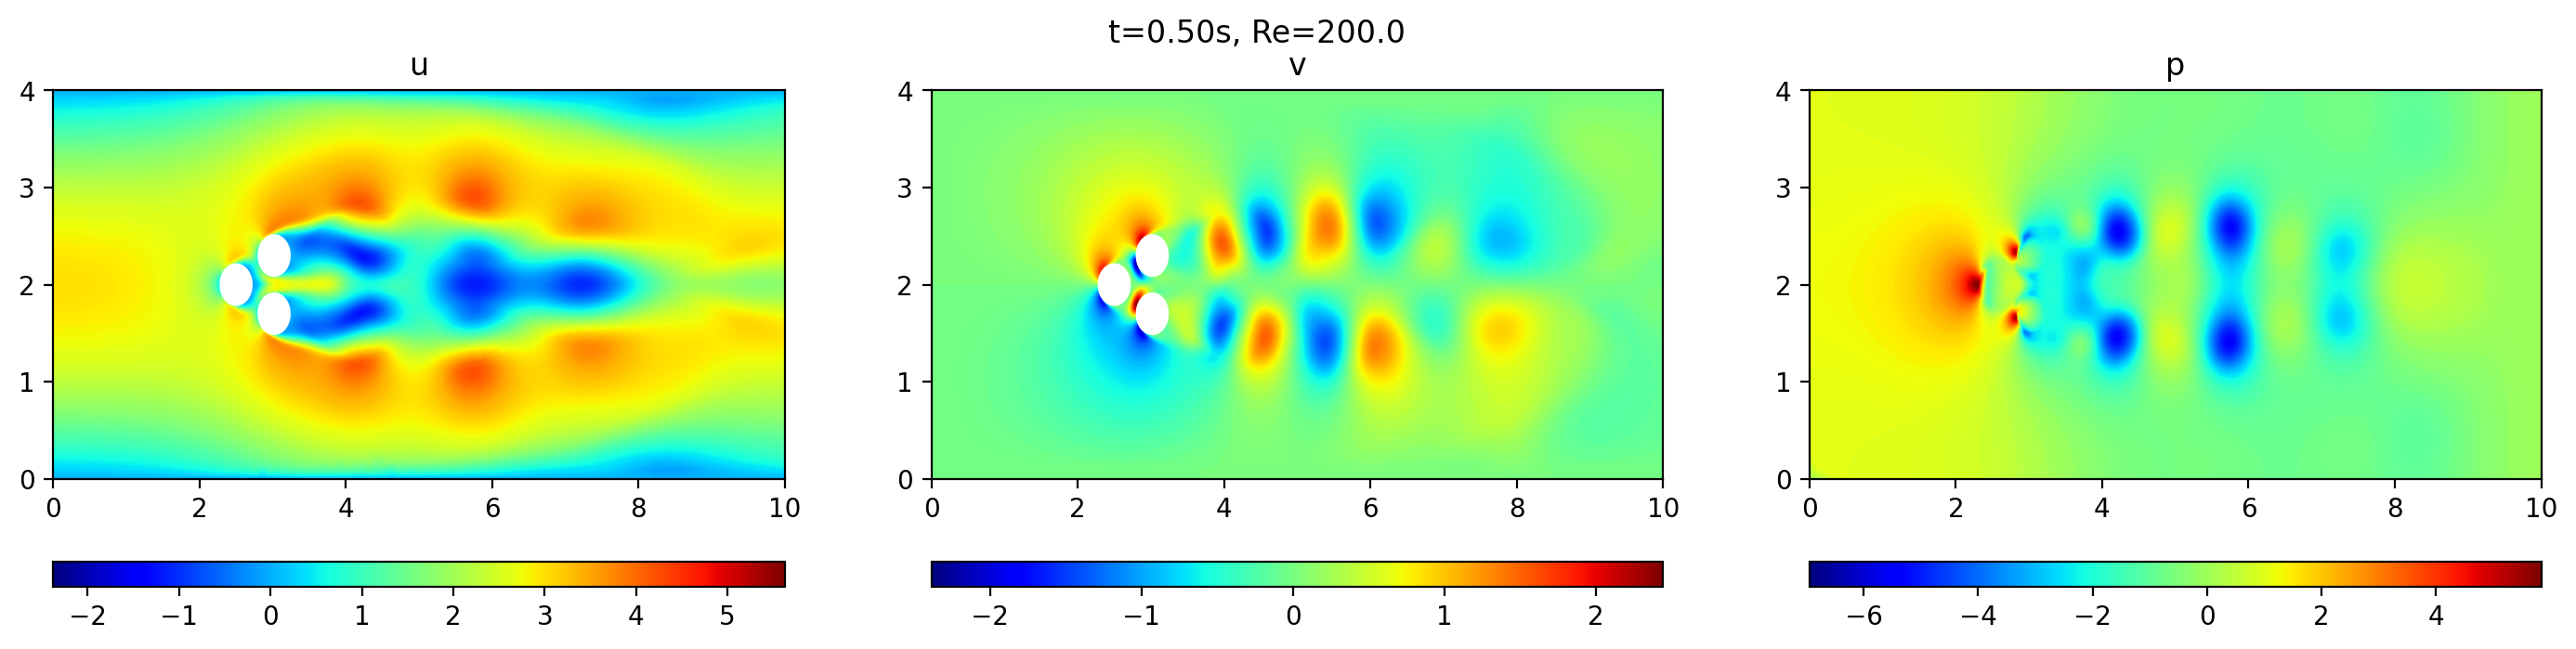

In [ ]:
%%px
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

if rank==0:
    fig, axs = plt.subplots(1, 3)
    # add_zoom(2.4)

    # add_zoom(2.4)

    plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.3)
    zoom = 2.7
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

    # Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
    cbar_u = fig.colorbar(sm_u, ax=axs[0], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[0].set_title("u")
    cbar_u = fig.colorbar(sm_v, ax=axs[1], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[1].set_title("v")
    cbar_p = fig.colorbar(sm_p, ax=axs[2], orientation='horizontal', pad = 0.15, aspect = 30)
    axs[2].set_title("p")

    # 2) Funzione di inizializzazione (vuota, serve se usi blit=True)
    def init():
        for ax in axs:
            ax.clear()
            ax.set_aspect("equal")
        # ricrea le colorbar se necessario, oppure lasciale fisse come qui
        return []

    # Qui mettiamo i contenitori per gli artisti che cambiano
    last_contours = []
    last_patches = []

    def update(frame):
        # 1) Rimuovi i vecchi TriContourSet
        for cs in last_contours:
            cs.remove()
        last_contours.clear()

        # 2) Rimuovi le patch dei cilindri
        for patch in last_patches:
            patch.remove()
        last_patches.clear()

        # 3) Ridisegna i contour
        cs1 = axs[0].tricontourf(
            triang, u_np[frame, :],
            cmap="jet", levels=200, norm=norm_u
        )
        cs2 = axs[1].tricontourf(
            triang, v_np[frame, :],
            cmap="jet", levels=200, norm=norm_v
        )
        cs3 = axs[2].tricontourf(
            triang, p_np[frame, :],
            cmap="jet", levels=200, norm=norm_p
        )

        # memorizza i TriContourSet
        last_contours.extend([cs1, cs2])

        # 4) Ridisegna il cilindro, tenendo le patch appena creare in una lista
        for cyl in cyl_coords:
            patch = axs[0].fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)[0]
            last_patches.append(patch)
            patch = axs[1].fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)[0]
            last_patches.append(patch)

        # 5) Aggiorna il titolo
        t_val = frame / timesteps * T
        Re = U_max * np.cos(params[0][0]) * 2 * R * rho_ / params[1][0]
        fig.suptitle(f"t={t_val:.2f}s, Re={Re:.1f}")

        # Ritorniamo i due TriContourSet (basta loro, matplotlib sa rinfrescare i patch)
        return last_contours

    # Costruiamo l'animazione
    n_frames = ntimes
    ani = FuncAnimation(
        fig, update, frames=range(n_frames),
        blit=True, interval=100
    )

    # # Per vederla in Jupyter:
    # from IPython.display import HTML
    # HTML(ani.to_jshtml())

    # Oppure per salvarla:
    ani.save("animazione.mp4", writer="ffmpeg", fps=10)